# Creating and Visualizing Molecular Fragments with RDKit.

The goal of this notebook is to explore how to get molecular fragments from circular fingerprints calculated by RDKit.
Additionally, we would like to visualize these fragments.  Ultimately, they will be used in a knowledge graph to help
describe molecules.

### Imports



In [47]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

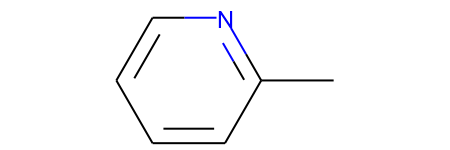

In [52]:
m = Chem.MolFromSmiles('c1cccnc1C')
info={}  # place to store info about the fingerprint.
fp = AllChem.GetMorganFingerprint(m,3,bitInfo=info)
m

In [49]:
env = Chem.FindAtomEnvironmentOfRadiusN(m,2,5)
amap={}
submol=Chem.PathToSubmol(m,env,atomMap=amap)
submol.GetNumAtoms()
subsmi = str(Chem.MolToSmiles(submol))
print(subsmi)
sub = Chem.MolFromSmiles(subsmi)  # doesnt work because the sub molecule
sub

ccc(C)nc


The below method does the same thing, but the documentation says it is more effecient, especially for large sets of molecules.

In [64]:
atoms=set()
for bidx in env:
    atoms.add(m.GetBondWithIdx(bidx).GetBeginAtomIdx())
    atoms.add(m.GetBondWithIdx(bidx).GetEndAtomIdx())

Chem.MolFragmentToSmiles(m,atomsToUse=list(atoms),bondsToUse=env,rootedAtAtom=5)

'c(C)(cc)nc'

## Visualizing Fragments
The above code to show the submolecule doesn't work because the sub-molecule smiles is invalid for a full molecule.
It has arromatic carbons listed in it, but no closed ring.  So we can get SMILES that way, but need another approach
to getting visuals.


{378: ((4, 0),), 1057: ((6, 0),), 1088: ((1, 1), (2, 1)), 1380: ((5, 0),), 1452: ((4, 1),), 1722: ((6, 1),), 1731: ((5, 1),), 1750: ((0, 1),), 1866: ((3, 1),), 1873: ((0, 0), (1, 0), (2, 0), (3, 0))}


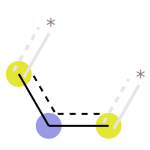

In [75]:
from rdkit.Chem import Draw

mol = Chem.MolFromSmiles('c1cccnc1C')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=1, bitInfo=bi)
mfp2_svg = Draw.DrawMorganBit(mol, 1088, bi, useSVG=True)
print(bi)
mfp2_svg


# len(fp.GetNonzeroElements())

So I think the dict `bi{}` contains a dictionary of non-zero bits.  The key is the bit number, the value is a tuple.
The first value in the tuple is what atom the fingerprint is centered upon and the second value is the
fingerprint radius.

If the key is tuples of tuples, then there are multiple atoms that produce that fragment.  For example, bit 1088 has the tuples `(1,1)` and `(2,1)`.
Can we print the smiles from here and would they be the same?


In [72]:
atoms = mol.GetNumAtoms()
print("Molecule has {} atoms".format(atoms))
for atom in range(atoms):
    print("Atom {}\n".format((atom)))
    for r in range(0,4):
        print("Radius:",r)
        # print()
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,r,atom)
        amap={}
        submol=Chem.PathToSubmol(mol,env,atomMap=amap)
        submol.GetNumAtoms()
        subsmi = str(Chem.MolToSmiles(submol))
        print(subsmi)

Molecule has 7 atoms
Atom 0

Radius: 0

Radius: 1
ccc
Radius: 2
cccc(C)n
Radius: 3
Cc1ccccn1
Atom 1

Radius: 0

Radius: 1
ccc
Radius: 2
ccccc
Radius: 3
Cc1ccccn1
Atom 2

Radius: 0

Radius: 1
ccc
Radius: 2
ccccn
Radius: 3
c1ccncc1
Atom 3

Radius: 0

Radius: 1
ccn
Radius: 2
cccnc
Radius: 3
Cc1ccccn1
Atom 4

Radius: 0

Radius: 1
cnc
Radius: 2
ccnc(c)C
Radius: 3
Cc1ccccn1
Atom 5

Radius: 0

Radius: 1
cc(C)n
Radius: 2
ccc(C)nc
Radius: 3
Cc1ccccn1
Atom 6

Radius: 0

Radius: 1
cC
Radius: 2
cc(C)n
Radius: 3
ccc(C)nc


## Fragment Catalogs

Something I found in RDKit getting started.  Docs don't explain it particularly well, so I am going to play around
with it.  See "Molecular Fragments" in
https://www.rdkit.org/docs/GettingStartedInPython.html

In [114]:
import os
from rdkit import RDConfig
fName=os.path.join(RDConfig.RDDataDir,'FunctionalGroups.txt')
from rdkit.Chem import FragmentCatalog
fparams = FragmentCatalog.FragCatParams(1,6,fName)
fparams.GetNumFuncGroups()

39

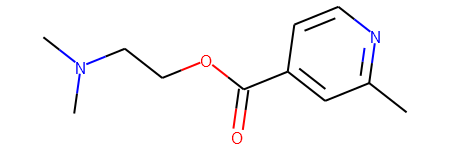

In [118]:
fcat=FragmentCatalog.FragCatalog(fparams)
fcgen=FragmentCatalog.FragCatGenerator()
m = Chem.MolFromSmiles('c1c(C(=O)OCCN(C)C)ccnc1C')
m

In [139]:
fcount = fcgen.AddFragsFromMol(m,fcat)
print(fcount)
fcgen.AddFragsFromMol(m,fcat)
print(fcat.GetNumEntries())
# for frag in range(fcount):
    print(fcat.GetEntryDescription(frag))
# fcat.GetEntryDescription(1)
#
# fcat.GetEntryDescription(2)
# fcat.GetEntryDescription(3)


# help(Chem.FragmentOnBonds)

0
100
Help on built-in function FragmentOnBonds in module rdkit.Chem.rdmolops:

FragmentOnBonds(...)
    FragmentOnBonds( (Mol)mol, (AtomPairsParameters)bondIndices [, (bool)addDummies=True [, (AtomPairsParameters)dummyLabels=None [, (AtomPairsParameters)bondTypes=None [, (list)cutsPerAtom=[]]]]]) -> Mol :
        Return a new molecule with all specified bonds broken
        
          ARGUMENTS:
        
              - mol            - the molecule to be modified
              - bondIndices    - indices of the bonds to be broken
              - addDummies  - toggles addition of dummy atoms to indicate where 
                bonds were broken
              - dummyLabels - used to provide the labels to be used for the dummies.
                the first element in each pair is the label for the dummy
                that replaces the bond's beginAtom, the second is for the 
                dummy that replaces the bond's endAtom. If not provided, the
                dummies are labeled w

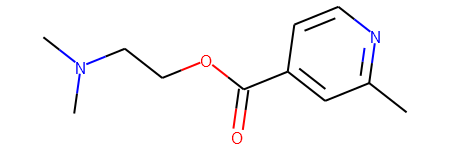

In [140]:
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
mol = Chem.MolFromSmiles('c1c(C(=O)OCCN(C)C)ccnc1C')
mol1 = Chem.Mol(mol)
mol1

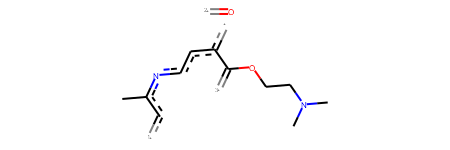

In [142]:
mol1_f = Chem.FragmentOnBonds(mol1, (0,2))
mol1_f

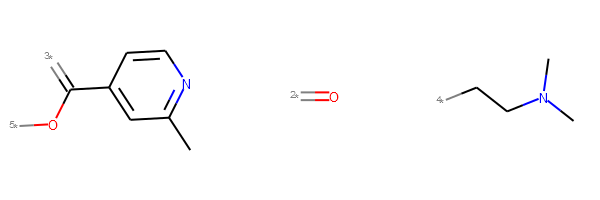

In [137]:
MolsToGridImage(Chem.GetMolFrags(mol1_f, asMols=True))
